In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from datetime import datetime

import warnings
warnings.filterwarnings(action="ignore")

from matplotlib import font_manager, rc
font_path = "C:\Windows\Fonts\gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

배경: (최근 여행 트렌드 키워드 뽑기): 근거리, 언택트, 안전 여행
분석 목적: 키워드에 적합한 여행지를 선정해보자
뉴노멀 시대 적합한 여행지 선정 ( 디테일 하게 )

1) 언택트
데이터: (교통이 불편한 곳 + 매출이 적은 곳 + 문화시설 수가 많은 곳) 
코로나 이후 트렌드에 적합한 여행 추천 => 온라인 컨텐츠 지역, 교통인프라 구축
(교통이 불편하고 문화시설이 많은 곳 => 비대면 여행지로 선정)

2) 근거리, 생활관광
데이터: (취급액 증가율이 높은 곳들(코로나 안전지역) + '자연' 문화시설이 많은 곳 20개를 지역)
생활관광지역으로 선정. 

3. 결론. 어떻게 5개의 지역을 선정할 것인가?

# 1. 매출이 적은 곳 선정

## (1). 매출이 적은 곳을 뽑기 위해서는 외국인의 매출 또한 포함시켜야한다.

In [2]:
native = pd.read_csv('./data/DATA_RE/NATIVE_RE.txt',sep = '|')
foreigner = pd.read_csv('./data/DATA_RE/FOREIGNER_RE.txt',sep = '|')

In [3]:
native.isna().sum()

v1                256988
v2                     0
v3                     0
gb3                    0
gb2                    0
sex_ccd                0
cln_age_r              0
ta_ym                  0
daw_ccd_r              0
apv_ts_dl_tm_r         0
vlm                    0
usec                   0
dtype: int64

In [4]:
foreigner.isna().sum()

nt                0
v2                0
v3                0
gb3               0
gb2               0
ta_ym             0
daw_ccd_r         0
apv_ts_dl_tm_r    0
vlm               0
usec              0
dtype: int64

In [5]:
# 정보 공개 제한으로 데이터 원본은 공개하지 않겠습니다.

In [6]:
# 'ta_ym' column string type으로 변환
native['ta_ym']= native['ta_ym'].astype('str')
foreigner['ta_ym']= foreigner['ta_ym'].astype('str')

# 'ta_ym' column에서 year, month column 추출
year = []
month = []
for i in native['ta_ym']:
    year.append(int(i[:4]))
    month.append(int(i[4:]))
native['year'] = year
native['month'] = month

year = []
month = []
for i in foreigner['ta_ym']:
    year.append(int(i[:4]))
    month.append(int(i[4:]))
foreigner['year'] = year
foreigner['month'] = month

In [7]:
# 불필요한 column 삭제
foreigner.drop(['nt','daw_ccd_r','apv_ts_dl_tm_r'],axis = 1, inplace = True)
native.drop(['v1','sex_ccd','cln_age_r','daw_ccd_r','apv_ts_dl_tm_r'],axis = 1, inplace = True)

In [8]:
# 지역을 기준으로 concat 할 것이기 때문에 맞춰주기
foreigner.drop(foreigner.loc[foreigner['v2'] == '*'].index, axis = 0, inplace =True)
native['v3'].loc[native['v3'] == '.'] = '특별시'
foreigner['v3'].loc[foreigner['v3'] == '세종'] = '특별시'

# 데이터 Concat
data_all = pd.concat([native,foreigner], axis = 0)
data_all.reset_index(drop = True, inplace = True)
data_all['지역'] = data_all['v2'] + data_all['v3']

In [9]:
data_all.head(3)

,v2,v3,gb3,gb2,ta_ym,vlm,usec,year,month,지역
0,세종,특별시,취미오락,외식,201701,351296766,19010,2017,1,세종특별시
1,세종,특별시,취미오락,종합쇼핑,201701,72244196,2375,2017,1,세종특별시
2,세종,특별시,취미오락,종합쇼핑,201701,532911085,19979,2017,1,세종특별시


## (2) 코로나 전후로 사용할 일 있으면 사용할 수 있게 데이터 나눠놓기

In [10]:
covid_before = data_all.loc[data_all['year'] <= 2019]
covid_after = data_all.loc[data_all['year'] >= 2020]
covid_before.reset_index(drop = True, inplace = True)
covid_after.reset_index(drop = True, inplace = True)

## (3) 매출이 적은 5곳 선정하기
- 2019년에서 2020년 금액, 이용건수의 감소률

- 2020년에서 2021년 금액, 이용건수의 감소률

1. 　2019년에서 2020년 감소률이 큰 지역
2. 　2020년에서 2021년 증가률이 작은 지역 (2021년 데이터는 5월까지 밖에 없기 때문에 비교 집단 또한 표본을 5월까지 한정)

In [11]:
Sort_City_Year = pd.DataFrame(data_all.groupby(['지역','year'])[['vlm','usec']].sum())
Sort_City_Year.reset_index(inplace = True)

Sort_City_Year2 = data_all.loc[data_all['month'] <= 5]
Sort_City_Year2 = pd.DataFrame(Sort_City_Year2.groupby(['지역','year'])[['vlm','usec']].sum())
Sort_City_Year2.reset_index(inplace = True)

In [12]:
Sort_City_Year_covid1 = Sort_City_Year.loc[(Sort_City_Year['year'] == 2019) | (Sort_City_Year['year'] == 2020)]
Sort_City_Year_covid2 = Sort_City_Year2.loc[(Sort_City_Year2['year'] == 2020) | (Sort_City_Year2['year'] == 2021)]
Sort_City_Year_covid1.reset_index(drop= True, inplace = True)
Sort_City_Year_covid2.reset_index(drop= True, inplace = True)

In [13]:
지역 = []
년도 = []
금액차이2019_2020 = []
건수차이2019_2020 = []
for i in range(0,len(Sort_City_Year_covid1),2):
    지역.append(Sort_City_Year_covid1['지역'][i])
    금액차이2019_2020.append(Sort_City_Year_covid1['vlm'][i] / Sort_City_Year_covid1['vlm'][i+1])
    건수차이2019_2020.append((Sort_City_Year_covid1['usec'][i] / Sort_City_Year_covid1['usec'][i+1]))


금액차이2020_2021 = []
건수차이2020_2021 = []
for i in range(0,len(Sort_City_Year_covid2),2):
    금액차이2020_2021.append(Sort_City_Year_covid2['vlm'][i] / Sort_City_Year_covid2['vlm'][i+1])
    건수차이2020_2021.append((Sort_City_Year_covid2['usec'][i] / Sort_City_Year_covid2['usec'][i+1]))

Covid = pd.DataFrame()
Covid['지역'] = 지역
Covid['금액차이 비율 2019 / 2020'] = 금액차이2019_2020
Covid['건수차이 비율 2019 / 2020'] = 건수차이2019_2020
Covid['금액차이 비율 2020 / 2021'] = 금액차이2020_2021
Covid['건수차이 비율 2020 / 2021'] = 건수차이2020_2021

In [14]:
Covid_cost_20192020 = Covid[['지역','금액차이 비율 2019 / 2020']]
Covid_cnt_20192020 = Covid[['지역','건수차이 비율 2019 / 2020']]
Covid_cost_20202021 = Covid[['지역','금액차이 비율 2020 / 2021']]
Covid_cnt_20202021 = Covid[['지역','건수차이 비율 2020 / 2021']]

Covid_cost_20192020.sort_values(['금액차이 비율 2019 / 2020'],ascending=False,ignore_index=True, inplace = True)
Covid_cnt_20192020.sort_values(['건수차이 비율 2019 / 2020'],ascending=False,ignore_index=True, inplace = True)
Covid_cost_20202021.sort_values(['금액차이 비율 2020 / 2021'],ascending=False,ignore_index=True, inplace = True)
Covid_cnt_20202021.sort_values(['건수차이 비율 2020 / 2021'],ascending=False,ignore_index=True, inplace = True)

In [15]:
# 각 지역별 순위를 담아두기
Covid_cost_20192020_area = Covid_cost_20192020['지역'].tolist()
Covid_cnt_20192020_area = Covid_cnt_20192020['지역'].tolist()
Covid_cost_20202021_area = Covid_cost_20202021['지역'].tolist()
Covid_cnt_20202021_area = Covid_cnt_20202021['지역'].tolist()

In [16]:
summary = pd.DataFrame()
summary['2019-2020 금액비율 하락 큰 순위'] = Covid_cost_20192020_area
summary['2019-2020 건수비율 하락 큰 순위'] = Covid_cnt_20192020_area
summary['2020-2021 금액비율 상승 작은 순위'] = Covid_cost_20202021_area
summary['2020-2021 건수비율 상승 작은 순위'] = Covid_cnt_20202021_area

In [17]:
summary

,2019-2020 금액비율 하락 큰 순위,2019-2020 건수비율 하락 큰 순위,2020-2021 금액비율 상승 작은 순위,2020-2021 건수비율 상승 작은 순위
0,전남무안군,인천남구,인천남구,인천중구
1,인천중구,인천중구,인천중구,강원태백시
2,서울강서구,부산중구,전북무주군,대전서구
3,서울종로구,대전동구,인천부평구,전북무주군
4,경기고양시,서울서대문구,인천계양구,대전중구
...,...,...,...,...
225,경기성남시,강원양양군,제주서귀포시,경기과천시
226,전남진도군,경기성남시,경북청도군,경북청도군
227,경북구미시,경남함안군,서울송파구,서울구로구
228,서울송파구,전남진도군,대구동구,서울송파구


In [18]:
Rank = pd.DataFrame()
Rank['지역'] = 지역
Rank['매출 점수'] = np.zeros(len(지역))

In [19]:
summary_all = [summary['2019-2020 금액비율 하락 큰 순위'],summary['2019-2020 건수비율 하락 큰 순위'],
              summary['2020-2021 금액비율 상승 작은 순위'],summary['2020-2021 건수비율 상승 작은 순위']]

for q in summary_all:
    cnt = 229
    for i in range(len(q)):
        for j in range(len(Rank)):
            if Rank['지역'][j] == q[i]:
                Rank['매출 점수'][j] += cnt
                cnt -= 1

Rank.sort_values(['매출 점수'],ascending=False, ignore_index=True, inplace = True)
Rank['매출 점수']=  Rank['매출 점수'] / 4
Rank

,지역,매출 점수
0,인천중구,228.25
1,인천남구,220.75
2,강원정선군,220.00
3,서울서대문구,217.75
4,서울종로구,216.00
...,...,...
225,강원양양군,10.75
226,서울마포구,8.00
227,서울구로구,7.25
228,경기성남시,6.25


In [20]:
temp = Sort_City_Year.loc[(Sort_City_Year['지역'] == '인천중구') | (Sort_City_Year['지역'] == '인천남구')| (Sort_City_Year['지역'] == '강원정선군')| (Sort_City_Year['지역'] == '서울서대문구') | (Sort_City_Year['지역'] == '서울종로구')]
temp.loc[(temp['year'] == 2019) | (temp['year'] == 2020) | (temp['year'] == 2021)]

,지역,year,vlm,usec
52,강원정선군,2019,185402267855,3923618
53,강원정선군,2020,117314347497,2966539
54,강원정선군,2021,43170950178,1045424
687,서울서대문구,2019,1584733448011,76291596
688,서울서대문구,2020,1218352772516,55009561
689,서울서대문구,2021,441812616668,19707345
732,서울종로구,2019,4110002840281,109622756
733,서울종로구,2020,2247951128003,82942892
734,서울종로구,2021,847293721919,31255862
787,인천남구,2019,37823032,1755


　
 　
  　
   　
    　
# 2. 교통이 불편한 지역 선정

## (1) 코로나 이전 카드에서 사용된 '교통'에 대한 소비는 코로나 이후 한국의 일반적인 교통에 대한 지표가 될 수 없다.
<img src = './data/코로나_전후_대중교통.PNG'>

        - image 출처(대한민국 정책 브리핑) : https://www.korea.kr/news/policyNewsView.do?newsId=148885347
        - data 출처(교통카드 빅데이터 시스템) : https://www.stcis.go.kr/wps/main.do

- 코로나 후라고 대중교통의 감축 등 다양한 정책으로 인해 다른 경향성을 보인다.

- 대분류에 있는 '교통' 에 대한 데이터는 여행이 목적이 아닌 모든 교통을 의미하기 때문에 대분류 '여행', 소분류 '교통' 에 대한 데이터를 사용한다.

### * 교통에 대한 이용금액은 큰 의미가 없다. 지역별로 대중교통의 이용금액이 다 다르기 때문에, 이용건수가 교통이 편리한 지역인가에 대한 데이터로 활용이 가능하다.

In [21]:
data = pd.read_csv('./data/공공요금.csv')
data_bus_taxi = data[['지역','시내버스(성인)카드','시내버스(성인)현금','택시료(중형)']]
data_bus_taxi.dropna(inplace = True)

In [22]:
data_bus_taxi[:10]

,지역,시내버스(성인)카드,시내버스(성인)현금,택시료(중형)
0,서울,1200.0,1300.0,3800.0
1,광주,1250.0,1400.0,3300.0
2,대구,1250.0,1400.0,3300.0
3,대전,1250.0,1400.0,3300.0
4,부산,1200.0,1300.0,3300.0
5,울산,1250.0,1300.0,3300.0
6,인천,1250.0,1270.0,3800.0
7,강원,1252.0,1378.0,3344.0
8,경기,1450.0,1500.0,3800.0
9,경남,1269.0,1350.0,3906.0


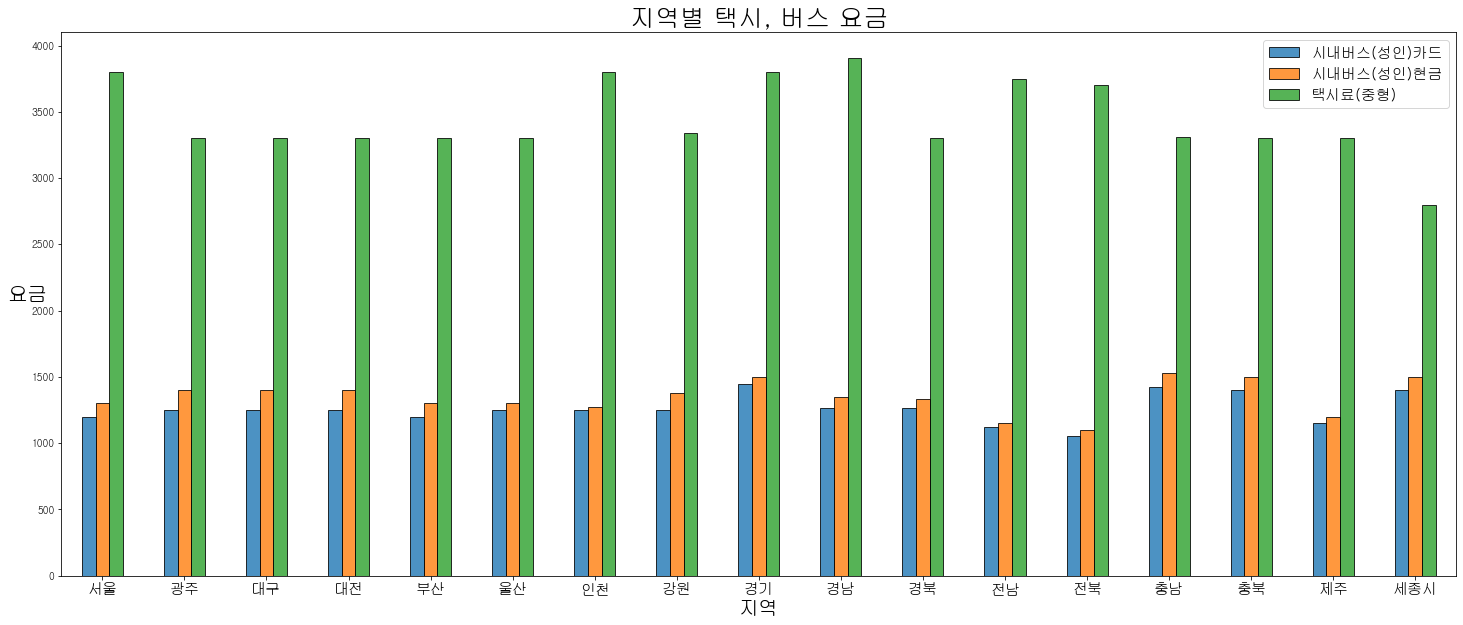

In [23]:
data_bus_taxi.plot(x="지역", y=["시내버스(성인)카드", "시내버스(성인)현금",'택시료(중형)'], kind="bar",figsize=(25,10),edgecolor='black',alpha=0.8, linewidth=1)
plt.title('지역별 택시, 버스 요금',fontsize=25)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15, rotation = 360)
plt.xlabel('지역',fontsize=20)
plt.ylabel('요금',fontsize=20, rotation = 360)
plt.show()

## (2) 카드 데이터에서 교통이 불편한 지역 데이터 만들기
- 내국인 데이터에서는 gb2 == '여행', gb3 == '교통' 
- 외국인 데이터에서는 gb2 == '교통'                  
    * 외국인 데이터에는 gb3 column 에 교통이 없고 gb2 column에 교통이 있다.
- 위 두 개를 Concat 한다.

In [24]:
native_covid = native.loc[(native['gb2'] == '교통') & ((native['year'] == 2020) | (native['year'] == 2021))]
foreigner_covid = foreigner.loc[(foreigner['gb3'] == '교통') & ((foreigner['year'] == 2020) | (foreigner['year'] == 2021))]

In [25]:
data_traffic = pd.concat([native_covid,foreigner_covid], axis = 0)
data_traffic.reset_index(drop = True, inplace = True)
data_traffic['지역'] = data_traffic['v2'] + data_traffic['v3']
data_traffic.drop(['v2','v3','gb3','gb2','ta_ym'], axis = 1, inplace = True)
data_traffic = data_traffic[['지역','year','month','usec']]

In [26]:
data_traffic

,지역,year,month,usec
0,대구동구,2020,1,5
1,부산북구,2020,1,5
2,울산북구,2020,1,5
3,서울중구,2020,1,15
4,인천중구,2020,1,10
...,...,...,...,...
287733,부산해운대구,2021,1,6
287734,부산해운대구,2020,10,8
287735,부산해운대구,2020,7,8
287736,부산해운대구,2020,11,2


In [27]:
summary_traffic = pd.DataFrame(data_traffic.groupby(['지역'])['usec'].sum())
summary_traffic.reset_index(inplace = True)
summary_traffic.sort_values(['usec'], ignore_index=True, inplace = True)

In [28]:
summary_traffic['교통 점수'] = 0
cnt = 229

for i in range(len(summary_traffic['교통 점수'])):
    summary_traffic['교통 점수'][i] = cnt
    cnt -= 1
    
summary_traffic.drop(['usec'], axis = 1, inplace = True)

In [29]:
Rank = pd.merge(summary_traffic, Rank,on = '지역')

In [30]:
Rank

,지역,교통 점수,매출 점수
0,인천남구,229,220.75
1,충남청양군,228,107.50
2,경남의령군,227,79.00
3,경북고령군,226,15.50
4,충북보은군,225,74.75
...,...,...,...
225,서울강서구,4,198.50
226,경기성남시,3,6.25
227,서울서초구,2,178.25
228,서울강남구,1,132.75


　
 　
  　
   　
# 3. 문화시설

## (1) 비대면 관광지

In [31]:
Cultural_facility = pd.read_csv('./data/문화시설수.csv')
del Cultural_facility['Unnamed: 0']
Cultural_facility.iloc[10030:10031, 1:2] = '울산'
Cultural_facility.iloc[10495:10496, 1:2] = '강원도'

Cultural_facility.iloc[10030:10031, 1:2] = '울주군'
Cultural_facility.iloc[10495:10496, 2:3] = '강릉시'
Cultural_facility = Cultural_facility.dropna()
Cultural_facility.rename(columns = {'인문' : '이름'}, inplace = True)
Cultural_facility.reset_index(drop= True, inplace = True)
Cultural_facility

a = {'울주군' : '울산','세종특별자치시' : '세종'}
Cultural_facility['도'].replace(a,inplace = True)
Cultural_facility['시군구'].loc[Cultural_facility['시군구'] == '울산시'] = '울주군'

temp = {'충청남도':'충남','경상북도':'경북','전라북도':'전북','경기도':'경기','충청북도':'충북','경상남도':'경남','전라남도':'전남','강원도':'강원','제주도':'제주','세종':''}
temp_2 = {'세종특별자치시' : '세종특별시'}
Cultural_facility['도'].replace(temp, inplace = True)
Cultural_facility['시군구'].replace(temp_2, inplace = True)

Cultural_facility['지역'] = Cultural_facility['도'] + Cultural_facility['시군구']
Cultural_facility.drop(['분류','도','시군구'], axis = 1, inplace = True)
Cultural_facility = Cultural_facility[['지역','이름','타입']]

In [32]:
Cultural_facility_H = Cultural_facility.loc[Cultural_facility['타입'] == '인문(문화_예술_역사)']
Cultural_facility_NL = Cultural_facility.loc[(Cultural_facility['타입'] == '자연') | (Cultural_facility['타입'] == '레포츠')]
Cultural_facility_NL.reset_index(drop = True,inplace = True)

In [33]:
Cultural_facility_H['개수'] = 1
summary_cultural_H = Cultural_facility_H.groupby(['지역'])[['개수']].sum()
summary_cultural_H.reset_index(inplace = True)
summary_cultural_H.sort_values(['개수'],ascending=False, ignore_index= True, inplace = True)

In [34]:
summary_cultural_H['문화시설 점수'] = 0
cnt = 229

for i in range(len(summary_cultural_H['문화시설 점수'])):
    summary_cultural_H['문화시설 점수'][i] = cnt
    cnt -= 1
    
summary_cultural_H.drop(['개수'], axis = 1, inplace = True)

Rank_H = Rank.copy()
Rank_H = pd.merge(summary_cultural_H, Rank_H,on = '지역')
Rank_H['총 점수'] = Rank_H['문화시설 점수'] + Rank_H['교통 점수'] + Rank_H['매출 점수']
Rank_H.sort_values(['총 점수'],ascending=False,ignore_index=True ,inplace = True)

print("전국 단위 비대면 관광지 추천 Top 5")
Rank_H[:5]

전국 단위 비대면 관광지 추천 Top 5


,지역,문화시설 점수,교통 점수,매출 점수,총 점수
0,강원정선군,147,198,220.00,565.00
1,전북무주군,135,222,167.25,524.25
2,강원화천군,151,183,187.50,521.50
3,강원평창군,206,157,152.75,515.75
4,강원홍천군,176,147,192.75,515.75


In [35]:
temp = native['v2'].unique().tolist()
index = []
for i in range(len(Rank_H)):
    for j in temp:
        if Rank_H['지역'][i][:2] == j:
            temp.remove(j)
            index.append(i)
        if len(temp) == 0:
            break
    if len(temp) == 0:
            break
            
print("광역시, 도 단위 Top 1 지역")
Rank_H.iloc[index]

광역시, 도 단위 Top 1 지역


,지역,문화시설 점수,교통 점수,매출 점수,총 점수
0,강원정선군,147,198,220.00,565.00
1,전북무주군,135,222,167.25,524.25
5,충북영동군,158,211,145.25,514.25
8,충남공주시,203,128,175.00,506.00
14,경북영주시,181,186,111.50,478.50
15,전남강진군,201,220,56.75,477.75
17,대구중구,193,158,116.50,467.50
20,서울종로구,229,15,216.00,460.00
21,인천강화군,212,199,48.50,459.50
24,경남밀양시,185,201,62.00,448.00


## (2) 언텍트 관광지

In [36]:
Cultural_facility_NL['개수'] = 1
summary_cultural_NL = Cultural_facility_NL.groupby(['지역'])[['개수']].sum()
summary_cultural_NL.reset_index(inplace = True)
summary_cultural_NL.sort_values(['개수'],ascending=False, ignore_index= True, inplace = True)

In [37]:
summary_cultural_NL['문화시설 점수'] = 0
cnt = 229

for i in range(len(summary_cultural_NL['문화시설 점수'])):
    summary_cultural_NL['문화시설 점수'][i] = cnt
    cnt -= 1
    
summary_cultural_NL.drop(['개수'], axis = 1, inplace = True)

Rank_NL = Rank.copy()
Rank_NL = pd.merge(summary_cultural_NL, Rank_NL,on = '지역')

Rank_NL['총 점수'] = Rank_NL['문화시설 점수'] + Rank_NL['교통 점수'] + Rank_NL['매출 점수']

Rank_NL.sort_values(['총 점수'],ascending=False,ignore_index=True ,inplace = True)

print("전국 단위 언텍트 관광지 추천 Top 5")
Rank_NL[:5]

전국 단위 언텍트 관광지 추천 Top 5


,지역,문화시설 점수,교통 점수,매출 점수,총 점수
0,강원정선군,202,198,220.00,620.00
1,전북무주군,218,222,167.25,607.25
2,강원양구군,174,196,181.00,551.00
3,강원평창군,225,157,152.75,534.75
4,강원홍천군,192,147,192.75,531.75


In [38]:
temp = native['v2'].unique().tolist()
index = []
for i in range(len(Rank_NL)):
    for j in temp:
        if Rank_NL['지역'][i][:2] == j:
            temp.remove(j)
            index.append(i)
        if len(temp) == 0:
            break
    if len(temp) == 0:
            break
            
print("광역시, 도 단위 Top 1 지역")
Rank_NL.iloc[index]

광역시, 도 단위 Top 1 지역


,지역,문화시설 점수,교통 점수,매출 점수,총 점수
0,강원정선군,202,198,220.00,620.00
1,전북무주군,218,222,167.25,607.25
8,경북울진군,184,188,114.50,486.50
11,충북제천시,185,145,148.25,478.25
12,전남진도군,212,219,46.25,477.25
13,충남보령시,204,159,114.00,477.00
14,광주북구,168,141,166.00,475.00
18,경기연천군,154,209,106.50,469.50
24,인천강화군,199,199,48.50,446.50
37,경남거창군,187,191,47.00,425.00


# 4. 결론
## (1) 비대면 관광지 확인

In [39]:
# 2019년 총 매출액, 2020년 총 매출액
Sort_City_Year_covid1.loc[Sort_City_Year_covid1['지역'] == '강원정선군']

,지역,year,vlm,usec
20,강원정선군,2019,185402267855,3923618
21,강원정선군,2020,117314347497,2966539


In [40]:
# 2020년 총 매출액, 2021년 총 매출액(1~5월까지)
Sort_City_Year_covid2.loc[Sort_City_Year_covid2['지역'] == '강원정선군']

,지역,year,vlm,usec
20,강원정선군,2020,52812294533,1265579
21,강원정선군,2021,43170950178,1045424


In [41]:
summary_traffic.loc[summary_traffic['지역'] == '강원정선군']

,지역,교통 점수
31,강원정선군,198


In [42]:
summary_cultural_H.loc[summary_cultural_H['지역'] == '강원정선군']

,지역,문화시설 점수
82,강원정선군,147


## (2) 언텍트 관광지 확인

In [43]:
# 2019년 총 매출액, 2020년 총 매출액
Sort_City_Year_covid1.loc[Sort_City_Year_covid1['지역'] == '강원정선군']

,지역,year,vlm,usec
20,강원정선군,2019,185402267855,3923618
21,강원정선군,2020,117314347497,2966539


In [44]:
# 020년 총 매출액, 2021년 총 매출액(1~5월까지)
Sort_City_Year_covid2.loc[Sort_City_Year_covid2['지역'] == '강원정선군']

,지역,year,vlm,usec
20,강원정선군,2020,52812294533,1265579
21,강원정선군,2021,43170950178,1045424


In [45]:
summary_traffic.loc[summary_traffic['지역'] == '강원정선군']

,지역,교통 점수
31,강원정선군,198


In [46]:
summary_cultural_H.loc[summary_cultural_H['지역'] == '강원정선군']

,지역,문화시설 점수
82,강원정선군,147
